## マイク補正ありでの測位


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_spectrum_amplitude
from positioning.sound_db import MicRevisionDB
from positioning import tools

In [3]:
db = MicRevisionDB("../data/reference_2d", "../data/mic-angle-10deg", interval=0.2)

In [4]:
true_pos = pd.read_csv("../data/pos2d_20230807/true_positions.csv", index_col=0)

In [5]:
est_poses = []
est_polars = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/pos2d_20230807/test{i}.wav")
    err = []
    pos = []
    polar = []
    for j in range(100):
        est_polar = np.ravel(
            db.positioning(test_signal[j * 96000 : (j + 2) * 96000], output="polar")
        )
        est_pos = tools.polar_to_rect(est_polar[1], np.radians(est_polar[0]))
        pos.append(est_pos)
        polar.append(est_polar)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    est_polars.append(polar)
    errors.append(err)

In [6]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["azimuth"] = np.array(est_polars[i])[:, 0]
    df_est_pos["distance"] = np.array(est_polars[i])[:, 1]
    df_est_pos["mic_angle"] = np.array(est_polars[i])[:, 2]
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])
df_est.reset_index(inplace=True, drop=True)

In [7]:
df_est.head()

,x,y,azimuth,distance,mic_angle,error,test_position
0,-0.570456,0.845736,-34.0,1.020142,34.0,0.061785,test0
1,-0.568722,0.843166,-34.0,1.017041,34.0,0.064873,test0
2,-0.565326,0.838130,-34.0,1.010968,35.0,0.070924,test0
3,-0.565326,0.838130,-34.0,1.010968,35.0,0.070924,test0
4,-0.567132,0.840808,-34.0,1.014197,35.0,0.067706,test0


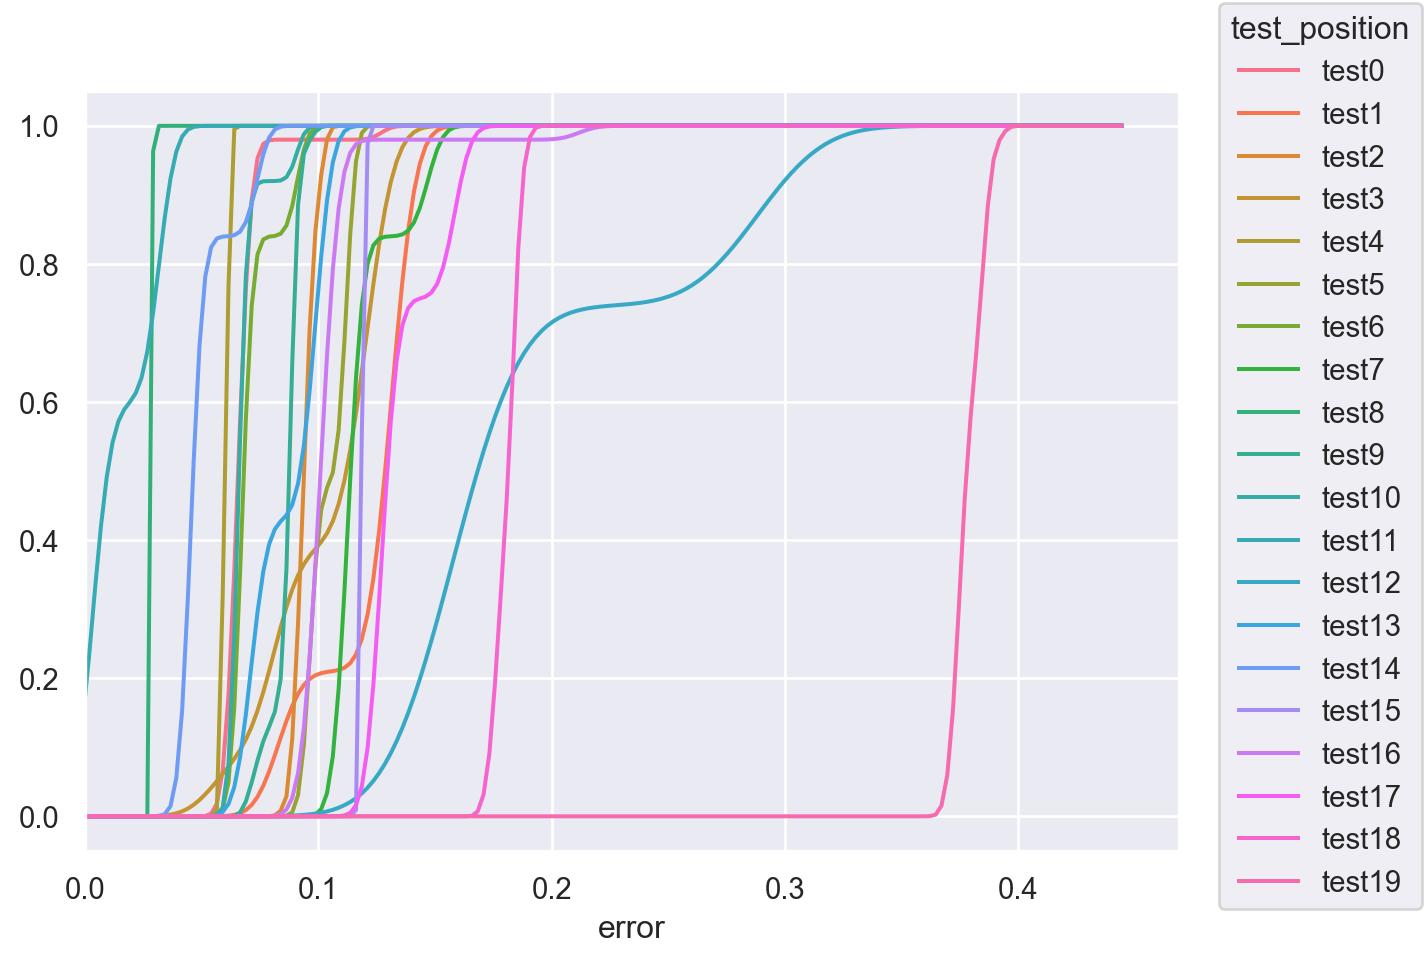

In [8]:
(
    so.Plot(df_est, x="error", color="test_position")
    .add(so.Lines(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [9]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.3+ KB


/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_32147/2238469347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions.loc[:, "true_or_test"] = "test"


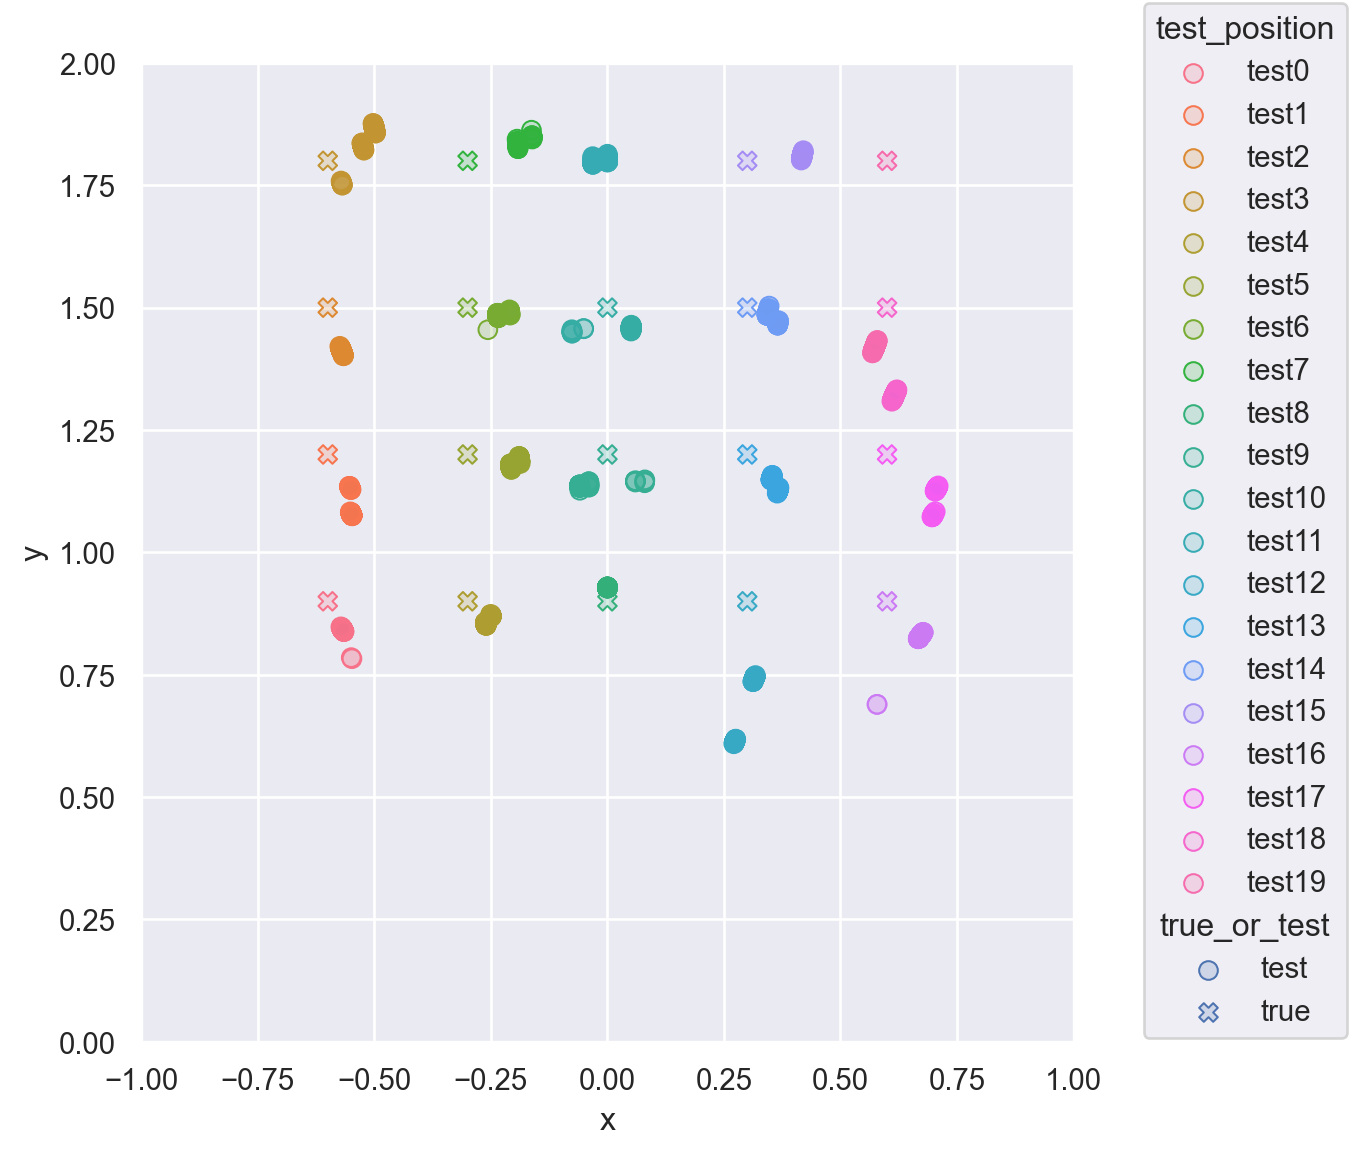

In [10]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)

In [11]:
true_distance, true_azimuth = tools.rect_to_polar(true_pos["x"], true_pos["y"])
true_pos["distance"] = true_distance
true_pos["azimuth"] = true_azimuth
true_pos["mic_angle"] = np.abs(true_pos["azimuth"])
true_pos.head()

,x,y,test_position,true_or_test,distance,azimuth,mic_angle
test0,-0.6,0.9,test0,true,1.081665,-33.690068,33.690068
test1,-0.6,1.2,test1,true,1.341641,-26.565051,26.565051
test2,-0.6,1.5,test2,true,1.615549,-21.801409,21.801409
test3,-0.6,1.8,test3,true,1.897367,-18.434949,18.434949
test4,-0.3,0.9,test4,true,0.948683,-18.434949,18.434949


In [12]:
df_polar = df_est[["distance", "azimuth", "mic_angle", "test_position"]]
df_polar.loc[:, "true_or_test"] = "test"
df_polar = pd.concat(
    [
        df_polar,
        true_pos[["distance", "azimuth", "mic_angle", "test_position", "true_or_test"]],
    ]
)
df_polar.reset_index(drop=True, inplace=True)
df_polar.head()

/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_32147/571681891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polar.loc[:, "true_or_test"] = "test"


,distance,azimuth,mic_angle,test_position,true_or_test
0,1.020142,-34.0,34.0,test0,test
1,1.017041,-34.0,34.0,test0,test
2,1.010968,-34.0,35.0,test0,test
3,1.010968,-34.0,35.0,test0,test
4,1.014197,-34.0,35.0,test0,test


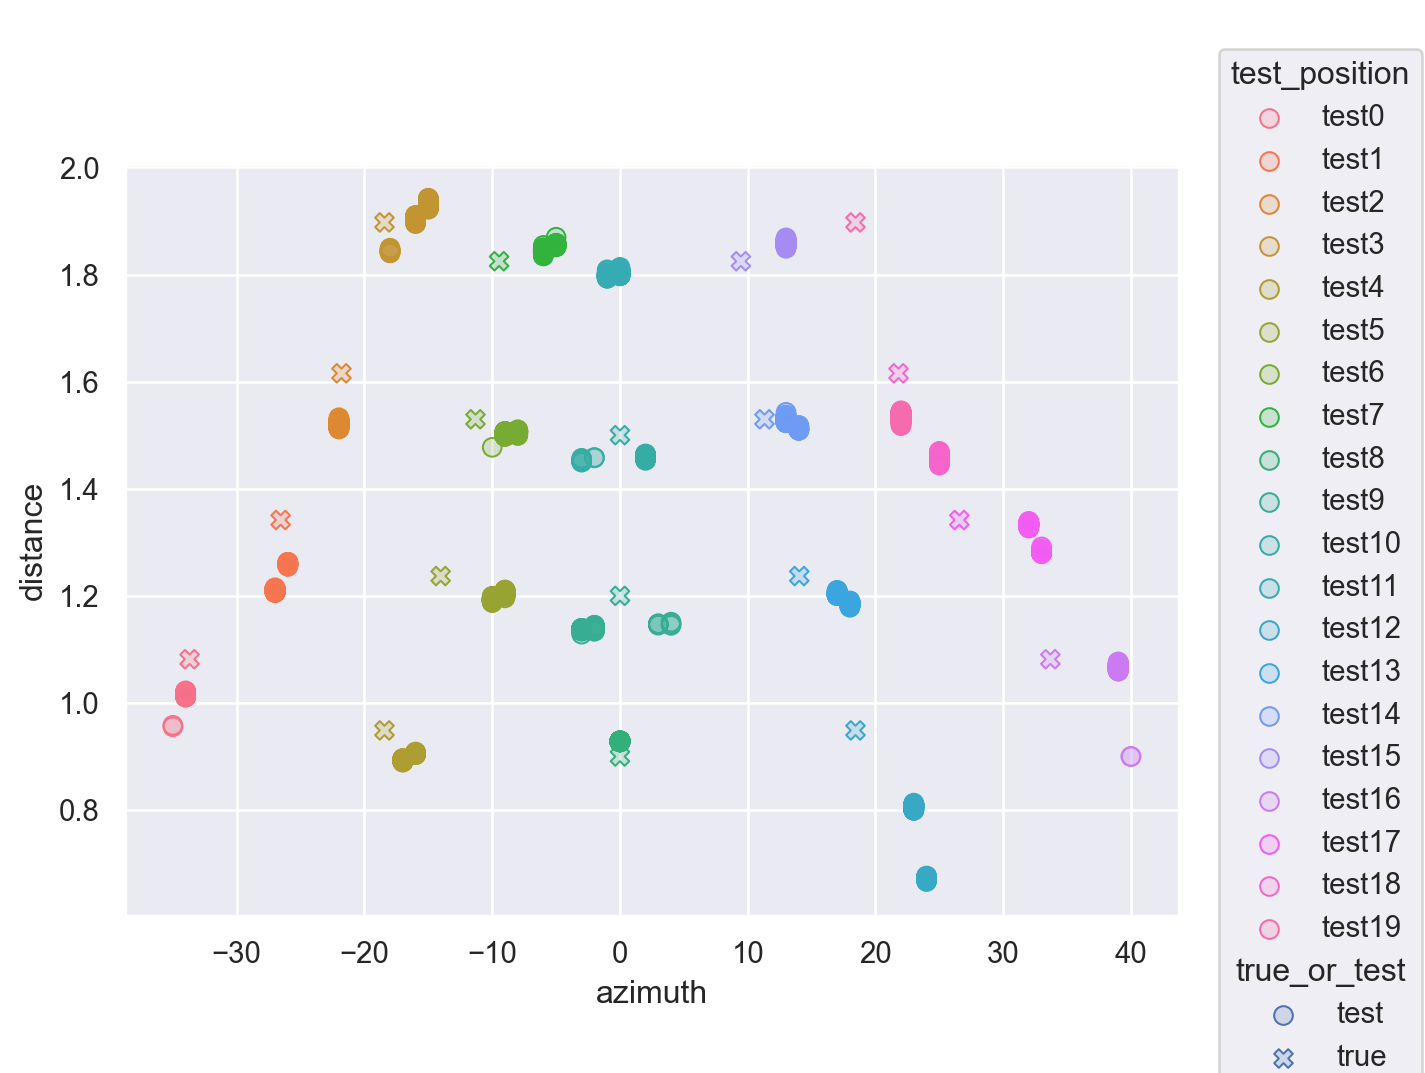

In [13]:
(
    so.Plot(
        df_polar,
        x="azimuth",
        y="distance",
        color="test_position",
        marker="true_or_test",
    ).add(so.Dots(pointsize=7))
)

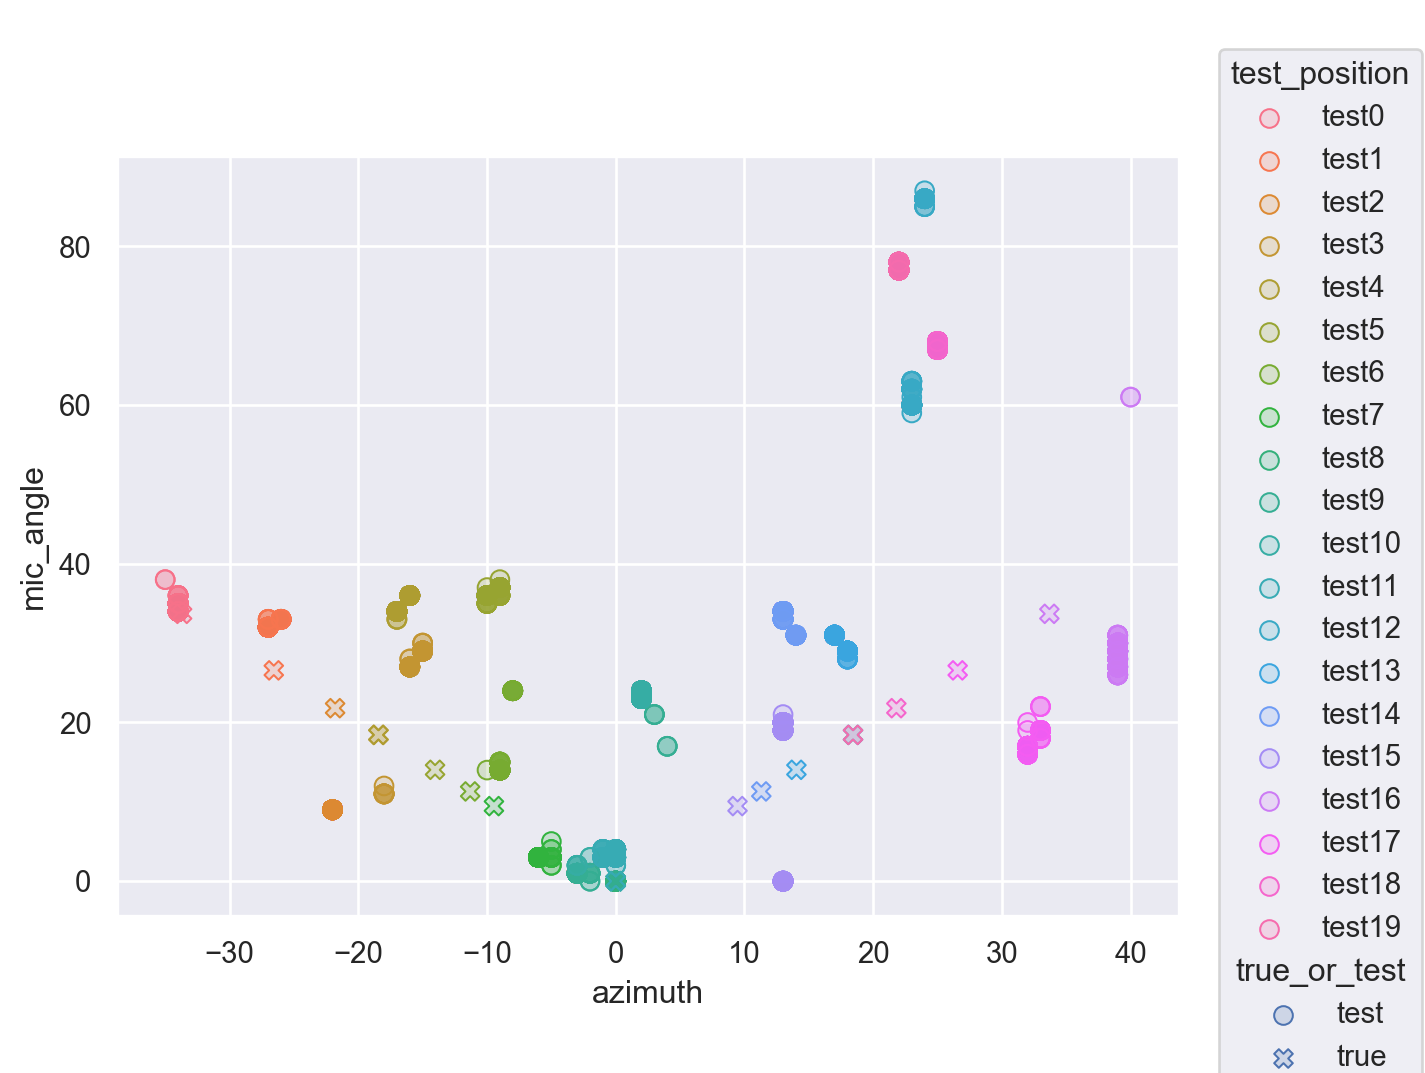

In [14]:
(
    so.Plot(
        df_polar,
        x="azimuth",
        y="mic_angle",
        color="test_position",
        marker="true_or_test",
    ).add(so.Dots(pointsize=7))
)

マイク補正が機能していない  
スペクトルをかけ合わせればいいというのは合ってる？  
例えば全く同じもの同士をかけたときに同じものが出てくるのか？  
掛け合わせるのはインパルス応答じゃないとダメ？？


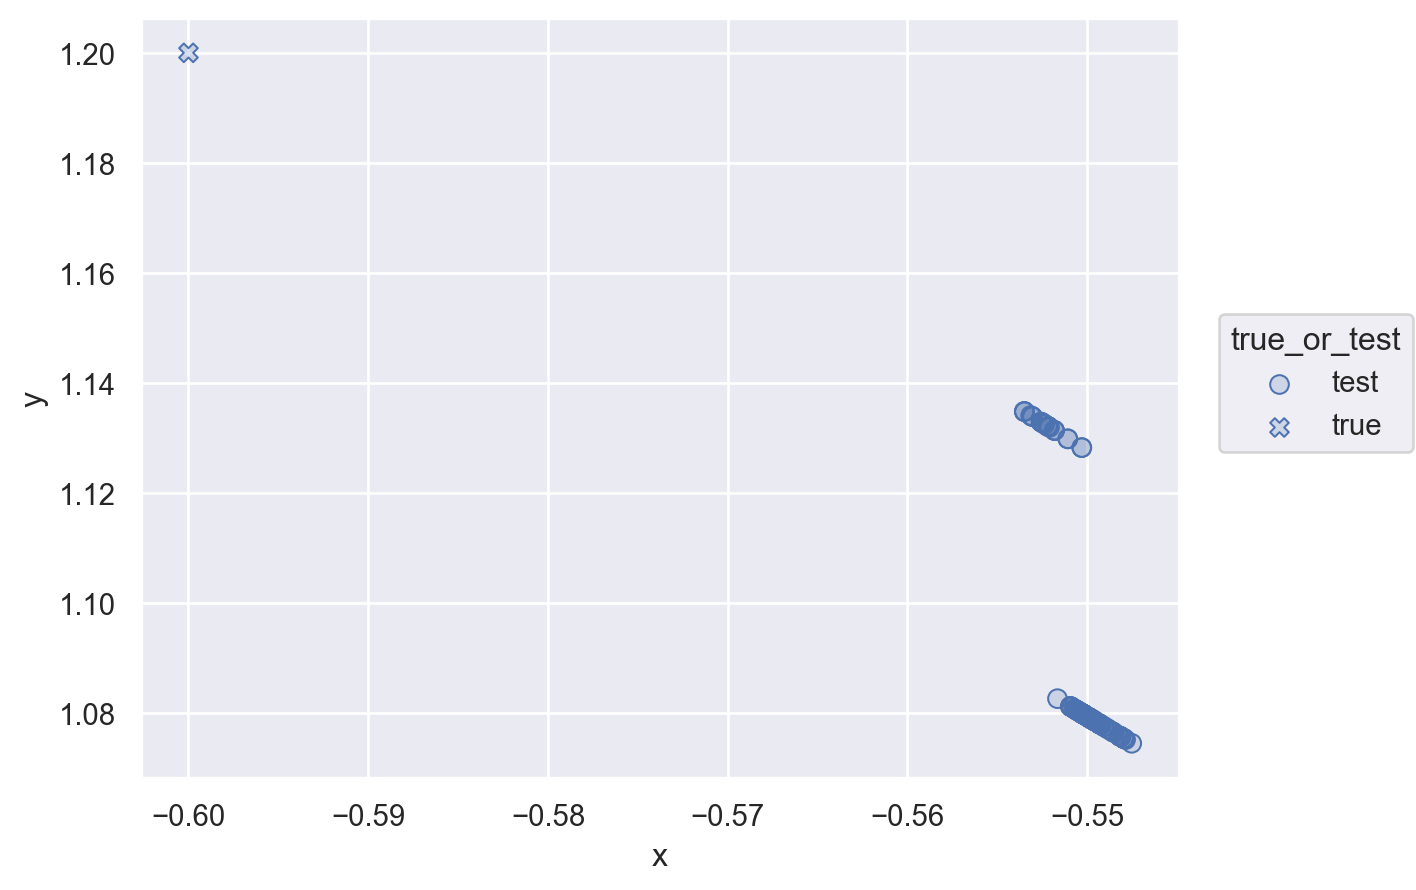

In [15]:
(
    so.Plot(
        df_positions.query("test_position == 'test1'"),
        x="x",
        y="y",
        marker="true_or_test",
    ).add(so.Dots(pointsize=7))
)

In [16]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,0.065508,0.068780
1,test1,0.130182,0.134506
2,test2,0.094025,0.099915
3,test3,0.119348,0.121984
4,test4,0.060239,0.061905
5,test5,0.110705,0.112522
6,test6,0.067322,0.090595
7,test7,0.112725,0.146555
8,test8,0.028144,0.028746
9,test9,0.087800,0.089207


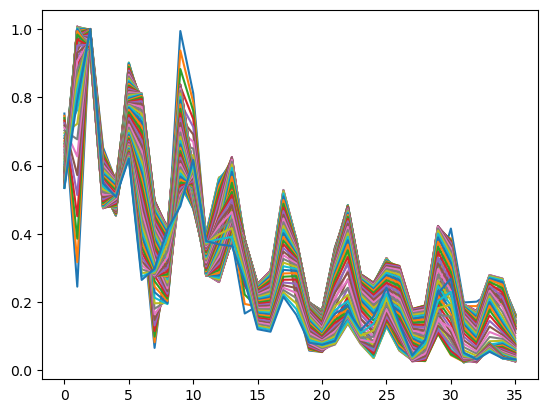

In [17]:
plt.plot(db.db[0][:, 0, :].T)

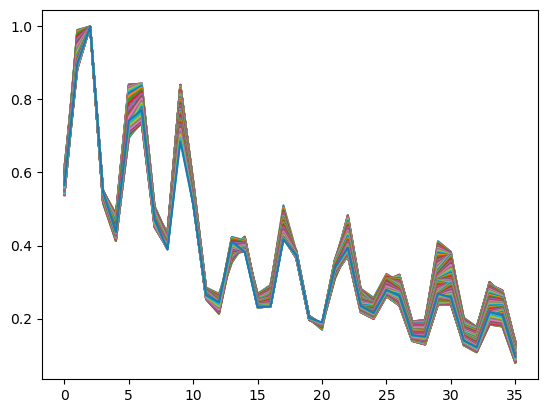

In [18]:
plt.plot(db.db[0][40, :, :].T)